# Catboost을 활용한 베이스라인

In [22]:
import pandas as pd
import os
import random
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path)

In [3]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 2. Feature Engineering

In [4]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [5]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.947683,1268,0.913187,3040


In [6]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [7]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# Remove LAST INTERACTION
test_df = test_df[test_df['userID'] == test_df['userID'].shift(-1)]


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259370 entries, 0 to 260112
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   userID               259370 non-null  int64  
 1   assessmentItemID     259370 non-null  object 
 2   testId               259370 non-null  object 
 3   answerCode           259370 non-null  int64  
 4   Timestamp            259370 non-null  object 
 5   KnowledgeTag         259370 non-null  int64  
 6   user_correct_answer  258626 non-null  float64
 7   user_total_answer    259370 non-null  int64  
 8   user_acc             258626 non-null  float64
 9   test_mean            259370 non-null  float64
 10  test_sum             259370 non-null  int64  
 11  tag_mean             259370 non-null  float64
 12  tag_sum              259370 non-null  int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 27.7+ MB


In [9]:
df = pd.concat([df,test_df], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525956 entries, 0 to 2525955
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   userID               int64  
 1   assessmentItemID     object 
 2   testId               object 
 3   answerCode           int64  
 4   Timestamp            object 
 5   KnowledgeTag         int64  
 6   user_correct_answer  float64
 7   user_total_answer    int64  
 8   user_acc             float64
 9   test_mean            float64
 10  test_sum             int64  
 11  tag_mean             float64
 12  tag_sum              int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 250.5+ MB


### Add Feature Engineering

In [14]:
# time_fe
def convert_time2timestamp(t):
    timestamp = time.mktime(t.timetuple())
    return int(timestamp)

def convert_string2datetime(s: str):
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S")

def timestamp_fe(df):
    ## 문자열로 인식되는 Timestamp의 타입을 datetime으로 변경하기. 
    df["Timestamp"] = df["Timestamp"].apply(convert_string2datetime) # string type to datetime type

    ## 기본적인 시간정보 추가
    df['year'] = df['Timestamp'].dt.year
    df['month'] = df['Timestamp'].dt.month
    df['day'] = df['Timestamp'].dt.day
    df['hour'] = df['Timestamp'].dt.hour                                       # 시간대로 범주 추가 가능

    ## 요일 추가
    df['wday'] = df['Timestamp'].dt.weekday # Monday ~ Sunday => 0 ~ 6         # 주말로 범주 추가 가능
    

    ## 문제를 다시 풀어본 횟수 feature 'retry' 추가
    test_group = df.groupby(['userID','testId']) # 같은 시험지끼리 묶어준다.
    # retry_check = 0
    retry_df = pd.DataFrame()
    for key, group in test_group:
        if len(group[group.assessmentItemID == group.assessmentItemID.iloc[0]]) >= 2:
            retry_df = pd.concat([retry_df,group.groupby('assessmentItemID').cumcount()])
            # retry_check += 1
    retry_df.columns=['retry']
    df = pd.merge(df, retry_df, left_index=True,right_index=True, how="left")
    df['retry'] = df['retry'].fillna(0) # retry의 결측치(한 번만 푼 문제들)을 0으로 바꿔준다.

    
    ## 문제 풀이 시간 추가
    df['time'] = df['time'] = df.groupby(['userID','testId','retry'])['Timestamp'].diff().shift(-1) # 문제 풀이 시간
    df['time'] = df['time'].fillna(df['time'].median())                       # Null값은 중앙값으로 채우기.
    df['time'] = df['time'].apply(lambda x:x.total_seconds())                  # 년,월,일,날짜로 되어있는 값을 시간초로 변환
    df['time'] = df['time'].apply(lambda x:300 if x > 300 else x)              # 최댓값을 300으로 변환. 95% 구간

    ## 문제 풀이 시간 분류 추가
    df['time_class'] = pd.qcut(df['time'],5, labels=[0,1,2,3,4])
    df['time_class'] = df['time_class'].astype(int) # int형으로 변환

    ## 전체적인 시간정보를 나타내는 Timestamp는 int형으로 변환.
    df["Timestamp"] = df["Timestamp"].apply(convert_time2timestamp) # datetime to timestamp

    return df

In [15]:
df = timestamp_fe(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,...,tag_mean,tag_sum,year,month,day,hour,wday,retry,time,time_class
0,0,A060001001,A060000001,1,1585009031,7224,NaN,0,NaN,0.947683,...,0.955022,637,2020,3,24,0,1,0.0,3.0,0
1,0,A060001002,A060000001,1,1585009034,7225,1.0,1,1.0,0.947683,...,0.913187,3040,2020,3,24,0,1,0.0,8.0,0
2,0,A060001003,A060000001,1,1585009042,7225,2.0,2,1.0,0.947683,...,0.913187,3040,2020,3,24,0,1,0.0,7.0,0
3,0,A060001004,A060000001,1,1585009049,7225,3.0,3,1.0,0.947683,...,0.913187,3040,2020,3,24,0,1,0.0,7.0,0
4,0,A060001005,A060000001,1,1585009056,7225,4.0,4,1.0,0.947683,...,0.913187,3040,2020,3,24,0,1,0.0,11.0,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525956 entries, 0 to 2525955
Data columns (total 21 columns):
 #   Column               Dtype   
---  ------               -----   
 0   userID               int64   
 1   assessmentItemID     object  
 2   testId               object  
 3   answerCode           int64   
 4   Timestamp            int64   
 5   KnowledgeTag         int64   
 6   user_correct_answer  float64 
 7   user_total_answer    int64   
 8   user_acc             float64 
 9   test_mean            float64 
 10  test_sum             int64   
 11  tag_mean             float64 
 12  tag_sum              int64   
 13  year                 int32   
 14  month                int32   
 15  day                  int32   
 16  hour                 int32   
 17  wday                 int32   
 18  retry                float64 
 19  time                 float64 
 20  time_class           category
dtypes: category(1), float64(6), int32(5), int64(7), object(2)
memory usage: 339.7

In [25]:
# testId
def testid_fe(df):
    ## test
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum','std'])
    correct_t.columns = ["test_ans_mean", 'test_ans_sum','test_ans_std']

    time_t = df.groupby(['testId'])['time'].agg(['mean', 'std'])
    time_t.columns = ["test_time_mean", 'test_time_std']

    ## 시험지 대분류(test_type)
    df['test_type'] = df['testId'].apply(lambda x:x[2])
    correct_type = df.groupby(['test_type'])['answerCode'].agg(['mean', 'sum','std'])
    correct_type.columns = ["t_type_ans_mean", 't_type_ans_sum','t_type_ans_std']

    time_type = df.groupby(['test_type'])['time'].agg(['mean', 'std'])
    time_type.columns = ["t_type_time_mean", 't_type_time_std']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, time_t, on=['testId'], how="left")
    df = pd.merge(df, correct_type, on=['test_type'], how="left")
    df = pd.merge(df, time_type, on=['test_type'], how="left")
    
    return df

In [26]:
df = testid_fe(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,...,test_ans_mean,test_ans_sum,test_ans_std,test_time_mean,test_time_std,t_type_ans_mean,t_type_ans_sum,t_type_ans_std,t_type_time_mean,t_type_time_std
0,0,A060001001,A060000001,1,1585009031,7224,NaN,0,NaN,0.947683,...,0.952667,1429,0.212422,22.584667,31.974308,0.712279,211037,0.452701,55.338564,70.427111
1,0,A060001002,A060000001,1,1585009034,7225,1.0,1,1.0,0.947683,...,0.952667,1429,0.212422,22.584667,31.974308,0.712279,211037,0.452701,55.338564,70.427111
2,0,A060001003,A060000001,1,1585009042,7225,2.0,2,1.0,0.947683,...,0.952667,1429,0.212422,22.584667,31.974308,0.712279,211037,0.452701,55.338564,70.427111
3,0,A060001004,A060000001,1,1585009049,7225,3.0,3,1.0,0.947683,...,0.952667,1429,0.212422,22.584667,31.974308,0.712279,211037,0.452701,55.338564,70.427111
4,0,A060001005,A060000001,1,1585009056,7225,4.0,4,1.0,0.947683,...,0.952667,1429,0.212422,22.584667,31.974308,0.712279,211037,0.452701,55.338564,70.427111


In [27]:
df.to_csv('./train_fe_2.csv', index=False)

## 3. Train/Test 데이터 셋 분리

In [39]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.9, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    train_test_list = []

    for i in range(10):
        print(users[:10])
        # users list 10%씩 뒤에 이어붙이기
        # ex) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] -> [10, 1, ..., 9]

        max_train_data_len = ratio*len(df)
        sum_of_train_data = 0
        user_ids = []
        train_ids = []
        test_ids = []
        
        for user_id, count in users:
            sum_of_train_data += count
            if max_train_data_len < sum_of_train_data:
                test_ids.append([user_id, count])
            else:
                user_ids.append(user_id)
                train_ids.append([user_id, count])

        users = test_ids + train_ids

        train = df[df['userID'].isin(user_ids)]
        test = df[df['userID'].isin(user_ids) == False]

        #test데이터셋은 각 유저의 마지막 interaction만 추출
        test_last = test[test['userID'] != test['userID'].shift(-1)]
        test_front = test[test['userID'] == test['userID'].shift(-1)]
        train = pd.concat([train, test_front], ignore_index=True)
        train_test_list.append([train, test_last])

    return train_test_list

In [40]:
# 유저별 분리
train_test_list = custom_train_test_split(df)

[(3781, 107), (4232, 297), (4615, 221), (7132, 26), (4896, 138), (4916, 102), (6327, 41), (5672, 62), (831, 261), (6101, 48)]
[[2660, 864], [5893, 46], [5225, 111], [4392, 215], [6806, 17], [909, 981], [321, 1126], [1685, 670], [2359, 567], [6577, 36]]
[[2352, 794], [4159, 102], [53, 692], [5419, 78], [5193, 88], [6066, 62], [3690, 79], [3668, 482], [3376, 106], [6680, 30]]
[[3863, 217], [4706, 157], [3122, 291], [6557, 32], [3199, 403], [2209, 395], [2075, 1004], [5839, 28], [81, 999], [348, 560]]
[[882, 1315], [1844, 662], [6323, 24], [2849, 511], [6186, 27], [2, 276], [1348, 1378], [1525, 972], [678, 860], [874, 1048]]
[[334, 1162], [351, 764], [5695, 90], [109, 1352], [41, 1050], [1996, 421], [215, 1326], [3, 1035], [5515, 171], [5023, 129]]
[[5594, 86], [5759, 98], [5142, 161], [3527, 212], [2387, 830], [2177, 820], [7415, 16], [1088, 922], [1469, 862], [6306, 97]]
[[3705, 451], [826, 476], [2308, 473], [4507, 170], [2097, 471], [4966, 171], [4639, 190], [3669, 140], [1796, 712], 

## 4. 훈련 및 검증

In [41]:
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold


In [42]:
seed = 42

model_list = []
n = 0

for train, test in train_test_list:
    print("============== " + str(n) + "th ==============")
    # 사용할 Feature 설정
    # FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
    #          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

    FEATS = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
            'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

    # FEATS = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag']

    # X, y 값 분리
    y_train = np.array(train['answerCode'])
    X_train = np.array(train.drop(['answerCode', 'Timestamp'], axis=1))

    y_valid = np.array(test['answerCode'])
    X_valid = np.array(test.drop(['answerCode', 'Timestamp'], axis=1))

    #print(X_train)

    model = CatBoostRegressor(cat_features = [1, 2],
                            iterations=1000,
                            random_seed=42,
                            learning_rate=0.1,
                            max_depth=5,
                            grow_policy="Depthwise",
                            verbose=100,
                            task_type="GPU")

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=500)

    preds = model.predict(X_valid)
    model_list.append(model)
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)

    print(f'VALID AUC : {auc} ACC : {acc}\n')
    
    n += 1

============== 0th ==============
0:	learn: 0.4638760	test: 0.5137991	best: 0.5137991 (0)	total: 18.2ms	remaining: 18.2s
100:	learn: 0.3999070	test: 0.4485724	best: 0.4485724 (100)	total: 1.44s	remaining: 12.8s
200:	learn: 0.3988994	test: 0.4481182	best: 0.4480422 (188)	total: 2.71s	remaining: 10.8s
300:	learn: 0.3982264	test: 0.4482291	best: 0.4480422 (188)	total: 3.99s	remaining: 9.26s
400:	learn: 0.3977309	test: 0.4475546	best: 0.4475159 (386)	total: 5.34s	remaining: 7.98s
500:	learn: 0.3972791	test: 0.4471166	best: 0.4470731 (497)	total: 6.79s	remaining: 6.76s
600:	learn: 0.3968864	test: 0.4467919	best: 0.4467848 (582)	total: 8.25s	remaining: 5.48s
700:	learn: 0.3965116	test: 0.4469095	best: 0.4467637 (666)	total: 9.65s	remaining: 4.12s
800:	learn: 0.3961991	test: 0.4467717	best: 0.4466855 (780)	total: 11s	remaining: 2.73s
900:	learn: 0.3959102	test: 0.4465567	best: 0.4465567 (900)	total: 12.4s	remaining: 1.36s
999:	learn: 0.3956166	test: 0.4465331	best: 0.4465231 (993)	total: 13.6

Text(0.5, 1.0, 'Feature Importance')

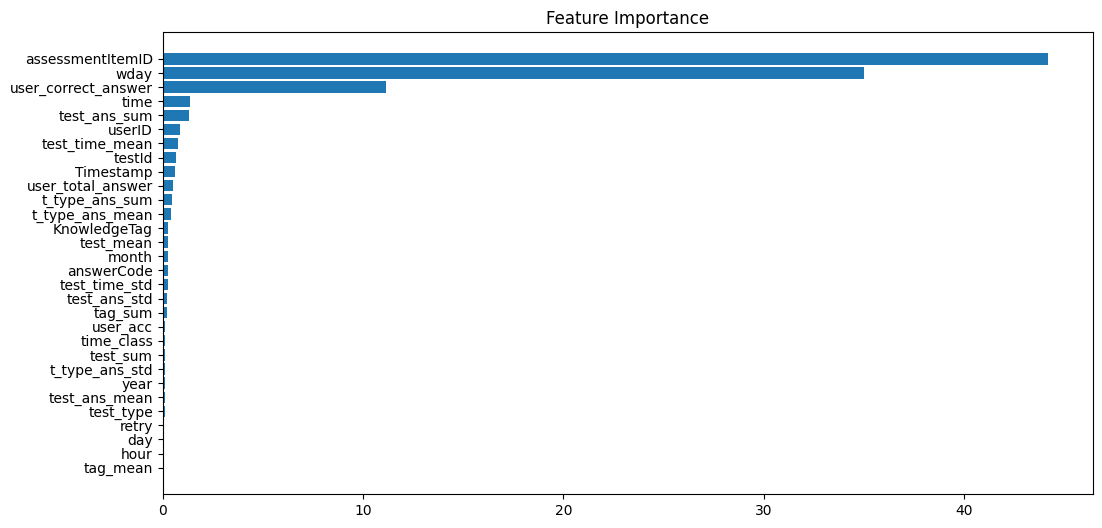

In [43]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
plt.title('Feature Importance')

## 5. Inference

In [44]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# add feature engineering
test_df = timestamp_fe(test_df)
test_df = testid_fe(test_df)
test_df['time_class'] = test_df['time_class'].astype(int) # int형으로 변환

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode', 'Timestamp'], axis=1)

In [45]:
# MAKE PREDICTION
total_pred_list = []

for model in model_list:
    total_pred_list.append(model.predict(test_df))

In [46]:
total_pred_list

[array([ 0.50491263,  0.59373554,  0.23647568,  0.61938992,  0.34205421,
         0.80691547,  0.45224561,  0.30875888,  0.26070662,  0.8565181 ,
         0.6119411 ,  0.11849642,  0.92475468,  0.22780526,  0.63882742,
         0.92030318,  0.1465564 ,  0.92542047,  0.7681339 ,  0.14402709,
         0.85892106,  0.55499715,  0.28196637,  0.29901938,  0.21989729,
         0.49906272,  0.89153746,  0.88310978,  0.46236636,  0.59359448,
         0.54157092,  0.70929789,  0.64436123,  0.29009798,  0.75153208,
         0.63750546,  0.2915603 ,  0.55203361,  0.44103029,  0.35715847,
         0.52742638,  0.19677813,  0.27963873,  0.19231544,  0.43196124,
         0.68286606,  0.62962218,  0.27609729,  0.88106061,  0.62866407,
         0.46024739,  0.40446194,  0.59415496,  0.2207153 ,  0.34323021,
         0.53686055,  0.46106271,  0.9932952 ,  0.34209216,  0.35913679,
         0.86646575,  0.87643643,  0.48776994,  0.27020258,  0.22915279,
         0.40117222,  0.64992082,  0.48601797,  0.2

In [47]:
total_preds = total_pred_list[0].copy()

for i in range(1, 10):
    total_preds += total_pred_list[i]

total_preds /= 10

In [48]:
# SAVE OUTPUT
output_dir = '/opt/ml/input/notebooks/output'
write_path = os.path.join(output_dir, "cat_reg_feat_10f_test_fe_2.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/input/notebooks/output/cat_reg_feat_10f_test_fe_2.csv


## Result

In [49]:
df = pd.read_csv('/opt/ml/input/notebooks/output/cat_reg_feat_10f_test_fe_2.csv')
df.head()

,id,prediction
0,0,0.520630
1,1,0.618061
2,2,0.309231
3,3,0.564476
4,4,0.356835


In [50]:
df2 = df.copy()
df2['prediction'] = df2['prediction'].apply(lambda x: 1 if x >= 0.5 else 0)
df2.head()

,id,prediction
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0


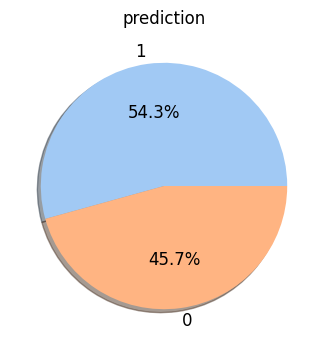

In [51]:
labels = df2['prediction'].unique()
ratio = df2[['prediction']].value_counts()
colors = sns.color_palette('pastel')[0:2]

fig = plt.figure(figsize=(5, 4))
plt.pie(ratio, labels=labels, autopct='%.1f%%', shadow=True, colors=colors, 
        textprops={'fontsize': 12})
plt.title('prediction')
plt.show()